<a href="https://colab.research.google.com/github/joshmaha/Image-Classification-using-CNN/blob/main/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>If you are running this tutorial on Windows or MacOS and encounter aBrokenPipeError or RuntimeError related to multiprocessing, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>

</div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]


Let us show some of the training images, for fun.


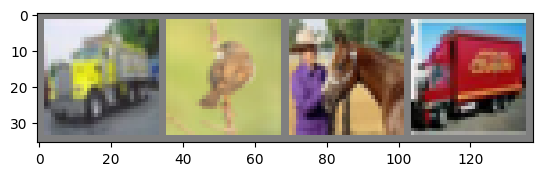

truck bird  horse truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
=======================================

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.837
[1,  6000] loss: 1.656
[1,  8000] loss: 1.558
[1, 10000] loss: 1.507
[1, 12000] loss: 1.447
[2,  2000] loss: 1.363
[2,  4000] loss: 1.347
[2,  6000] loss: 1.309
[2,  8000] loss: 1.298
[2, 10000] loss: 1.273
[2, 12000] loss: 1.257
Finished Training


Let\'s quickly save our trained model:


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


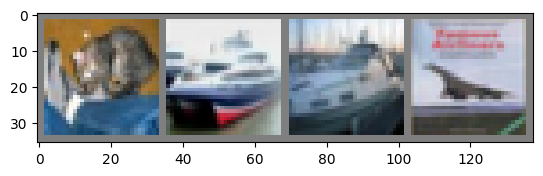

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [10]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [11]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.0 %
Accuracy for class: car   is 72.7 %
Accuracy for class: bird  is 36.5 %
Accuracy for class: cat   is 12.2 %
Accuracy for class: deer  is 44.5 %
Accuracy for class: dog   is 57.5 %
Accuracy for class: frog  is 81.6 %
Accuracy for class: horse is 63.3 %
Accuracy for class: ship  is 73.7 %
Accuracy for class: truck is 57.9 %


# Task 1

### import needed libraries

In [15]:
# import needed libraries

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

### Train models

In [16]:
# ensure we use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# make 2 different networks
net1 = Net().to(device)
net2 = Net().to(device)


# shuffle data differently by changing shuffle orders
order1 = np.random.randint(0, 100000) # generate random number for firs network
order2 = np.random.randint(0, 100000)

rand_shuffle_net1 = torch.Generator().manual_seed(order1)  # manual_seed sets the starting point for the randomness at seed1
rand_shuffle_net2 = torch.Generator().manual_seed(order2)

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# trainset is the same dataset for both but independently shuffled
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          generator=rand_shuffle_net1)

trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          generator=rand_shuffle_net2)

# both networks have testloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


# independent loss functions + optimizers
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()

optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)


# Train loop for net1
print("Training Model 1")

for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()

        running_loss += loss.item()
        # print statistics
        if i % 2000 == 1999:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss/2000:.3f}")
            running_loss = 0.0
print("Finished training model 1\n")


# train loop for net2
print("Training Model 2")


for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader2, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer2.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()
        # print statistics
        if i % 2000 == 1999:
            print(f"[{epoch+1}, {i+1}] loss: {running_loss/2000:.3f}")
            running_loss = 0.0

print("Finished training model 2\n")


Training Model 1
[1, 2000] loss: 2.173
[1, 4000] loss: 1.827
[1, 6000] loss: 1.651
[1, 8000] loss: 1.581
[1, 10000] loss: 1.503
[1, 12000] loss: 1.451
[2, 2000] loss: 1.380
[2, 4000] loss: 1.348
[2, 6000] loss: 1.330
[2, 8000] loss: 1.287
[2, 10000] loss: 1.284
[2, 12000] loss: 1.269
[3, 2000] loss: 1.176
[3, 4000] loss: 1.184
[3, 6000] loss: 1.181
[3, 8000] loss: 1.152
[3, 10000] loss: 1.164
[3, 12000] loss: 1.160
[4, 2000] loss: 1.083
[4, 4000] loss: 1.079
[4, 6000] loss: 1.071
[4, 8000] loss: 1.070
[4, 10000] loss: 1.063
[4, 12000] loss: 1.064
[5, 2000] loss: 0.986
[5, 4000] loss: 0.985
[5, 6000] loss: 1.009
[5, 8000] loss: 1.013
[5, 10000] loss: 1.022
[5, 12000] loss: 0.999
Finished training model 1

Training Model 2
[1, 2000] loss: 2.127
[1, 4000] loss: 1.785
[1, 6000] loss: 1.625
[1, 8000] loss: 1.555
[1, 10000] loss: 1.512
[1, 12000] loss: 1.458
[2, 2000] loss: 1.409
[2, 4000] loss: 1.363
[2, 6000] loss: 1.338
[2, 8000] loss: 1.323
[2, 10000] loss: 1.311
[2, 12000] loss: 1.282
[

### Get accuracy and agreement score

In [24]:
# get test accuracy for both models
def test_accuracy(net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            # images, labels = data # had to change this line
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100.0 * correct / total

# print results
accuracy1 = test_accuracy(net1)
accuracy2 = test_accuracy(net2)
print(f'Accuracy of the net1 on the 10000 test images: {accuracy1:.2f} %')
print(f'Accuracy of the net2 on the 10000 test images: {accuracy2:.2f} %')


# calculate agreement score between both networks
def ascore(net1, net2, test_images):

    matches = 0 # prepare to count matches of predictions
    total = 10000 # total amount of images in the dataset

    # again no gradients needed
    with torch.no_grad():
        for images, _ in testloader:   # labels not needed as we just need to know which predictions matched between the 2 networks
            images = images.to(device)

            # top1 predictions from both networks
            outputs1 = net1(images)
            outputs2 = net2(images)

            _, predicted1 = torch.max(outputs1, 1) # takes the highest energy from all 10 classes as its prediction
            _, predicted2 = torch.max(outputs2, 1)

            # count images where both predictions match
            matches += (predicted1 == predicted2).sum().item()

    return 100.0 * matches / total

agreement_score = ascore(net1, net2, testloader)
print(f"Agreement Score between net1 and net2: {agreement_score:.2f}%")


Accuracy of the net1 on the 10000 test images: 63.73 %
Accuracy of the net2 on the 10000 test images: 59.60 %
Agreement Score between net1 and net2: 60.60%


## Analysis



# Task 2

### get samples set for each class

In [35]:
# get 100 test images from each class
random.seed(0)  # make results reproducible

# dictionary to store test image indices for each class
indices_by_class = {a: [] for a in range(10)}

# fill the dictionary with every indices belonging to each class
for ind, (_, label) in enumerate(testset): # place each image in designated class
    indices_by_class[label].append(ind)

# sample 100 indices from each class
sampled_indices_by_class = {}
for a in range(10):
    sampled_indices_by_class[a] = random.sample(indices_by_class[a], 100)


### calculate entropy for each class

In [52]:
# get average entropy for each class
def avg_entropy(net, testset, sampled_indices_by_class):

    avg_entropy = {}
    with torch.no_grad():
        for a in range(10):
            entropies = []

            # fetch all sampled images for class c
            indices = sampled_indices_by_class[a]

            for index in indices:
                image, _ = testset[index]
                image = image.unsqueeze(0).to(device)  # add batch dimension because pytorch expects 4D input for CNN

                # forward pass -> probabilities
                logits = net(image) # network outputs raw scores not probabilities
                probs = F.softmax(logits, dim=1) # use softmax to get probabilities and all values sum to 1

                # entropy is the -sum(p * log(p))
                entropy = -torch.sum(probs * torch.log(probs + 1e-12))
                entropies.append(entropy.item()) # add entropy to list

            # average entropy for this class
            avg_entropy[a] = sum(entropies) / len(entropies)

    return avg_entropy

net1_entrop = avg_entropy(net1, testset, sampled_indices_by_class)

print("Average entropy per class for net1:\n")
for classname in range(10):
    print(f"Class {classes[classname]:5s}: {net1_entrop[classname]:.4f}")



Average entropy per class for net1:

Class plane: 1.0838
Class car  : 0.6380
Class bird : 1.0738
Class cat  : 1.2797
Class deer : 1.3570
Class dog  : 1.0907
Class frog : 0.8397
Class horse: 0.9125
Class ship : 0.7504
Class truck: 1.0301


### find accuracy for each class

In [59]:
def per_class_accuracy(net, testloader, classes):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for images, labels in testloader: # unpack data in for loop
            # images, labels = data # can't load like this as
            images, labels = images.to(device), labels.to(device) # assign o
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                label_name = classes[label]
                # if label == prediction:
                #     correct_pred[label_name] += 1
                # total_pred[label_name] += 1
                if label == prediction:
                   correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    per_class_acc = {}
    for classname in classes:
        per_class_acc[classname] = 100.0 * float(correct_pred[classname]) / total_pred[classname]
    return per_class_acc

net1_class_acc = per_class_accuracy(net1, testloader, classes)

# print accuracy for each class
print("Per-class accuracy for net1:\n")
for classname in classes:
    print(f'Accuracy for class: {classname:5s} is {net1_class_acc[classname]:.2f}%')

Per-class accuracy for net1:

Accuracy for class: plane is 59.90%
Accuracy for class: car   is 76.30%
Accuracy for class: bird  is 52.90%
Accuracy for class: cat   is 45.60%
Accuracy for class: deer  is 51.60%
Accuracy for class: dog   is 55.80%
Accuracy for class: frog  is 78.10%
Accuracy for class: horse is 67.50%
Accuracy for class: ship  is 78.50%
Accuracy for class: truck is 71.10%


### Analysis

# Task 3

In [60]:
# get Cifar100 data set
cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False,
                                              download=True, transform=transform)

100%|██████████| 169M/169M [00:04<00:00, 41.2MB/s]


In [61]:
# make dictionary to store and group indices into their own classes
indices_c100 = {c: [] for c in range(100)}

for idx, (_, label) in enumerate(cifar100_test):
    indices_c100[label].append(idx)


In [64]:
# for each class get the total count

def class_prediction_distribution(net, dataset, indices_by_class):
    net.eval()
    class_distributions = {}  # maps class_id -> [counts over 10 CIFAR10 classes]

    with torch.no_grad():
        for class_id in range(100):
            counts = torch.zeros(10)  # CIFAR-10 has 10 classes

            for idx in indices_by_class[class_id]:  # 100 images
                img, _ = dataset[idx]
                img = img.unsqueeze(0).to(device)

                logits = net(img)
                _, pred = torch.max(logits, 1)  # CIFAR-10 prediction

                counts[pred.item()] += 1

            class_distributions[class_id] = counts

    return class_distributions

c100_distributions = class_prediction_distribution(net1, cifar100_test, indices_c100)

# convert counts to probability distribution
prob_distributions = {c: dist / dist.sum() for c, dist in c100_distributions.items()}


In [66]:
# comput entropy for each class
def entropy_from_prob_vector(p):
    p = p + 1e-12
    return float(-(p * torch.log(p)).sum())

class_entropies = {
    c: entropy_from_prob_vector(prob_distributions[c])
    for c in range(100)
}


In [68]:
# get best and worst entropy classes
sorted_classes = sorted(class_entropies.items(), key=lambda x: x[1])

lowest_5 = sorted_classes[:5]
highest_5 = sorted_classes[-5:]

print("Lowest 5 entropy classes:")
print(lowest_5)

print("\nHighest 5 entropy classes:")
print(highest_5)


Lowest 5 entropy classes:
[(71, 1.0271836519241333), (58, 1.0765187740325928), (2, 1.3340120315551758), (13, 1.3533875942230225), (36, 1.3587392568588257)]

Highest 5 entropy classes:
[(91, 2.1522672176361084), (55, 2.155299663543701), (99, 2.161044120788574), (84, 2.1751720905303955), (75, 2.2401328086853027)]


In [70]:
# create guassian noise
noise_images = torch.randn(100, 3, 32, 32).to(device)  # mean=0, std=1

# predict classes given noise
with torch.no_grad():
    logits = net1(noise_images)
    _, preds = torch.max(logits, 1)

# count predictions
noise_counts = torch.bincount(preds, minlength=10)
noise_prob = noise_counts / noise_counts.sum()
noise_entropy = entropy_from_prob_vector(noise_prob)

print("Noise prediction distribution:", noise_prob)
print("Noise entropy:", noise_entropy)



Noise prediction distribution: tensor([0.0000, 0.0400, 0.0000, 0.0200, 0.0000, 0.0100, 0.0300, 0.0500, 0.0000,
        0.8500], device='cuda:0')
Noise entropy: 0.6461716294288635
